<a href="https://colab.research.google.com/github/d61h6k4/notebooks/blob/master/Custom_3d_engine_in_Matplotlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The source of information is [here](https://matplotlib.org/matplotblog/posts/custom-3d-engine/)

In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot
import numpy as np
import requests
import tqdm

Load *simplified* version of Stanford's bunny

In [0]:
class GeometricVertex(object):
    @staticmethod
    def from_bytes(bs):
        return np.array([float(x) for x in bs.split()[1:4]])


class Face(object):
    @staticmethod
    def from_bytes(bs):
        return np.array([int(x) for x in bs.split()[1:4]])

In [15]:
r = requests.get('https://matplotlib.org/matplotblog/posts/custom-3d-engine/bunny.obj')

assert r.status_code == 200

V = []
F = []
for row in tqdm.tqdm(r.content.split(b'\r\n')):
    if row.startswith(b'#'):
        print(row.decode('utf-8'))
    elif row.startswith(b'v'):
        V.append(GeometricVertex.from_bytes(row))
    elif row.startswith(b'f'):
        F.append(Face.from_bytes(row))

V = np.array(V)
F = np.array(F) - 1

100%|██████████| 7475/7475 [00:00<00:00, 257864.23it/s]

# OBJ file format with ext .obj
# vertex count = 2503
# face count = 4968


In [0]:
V = (V-(V.max(0)+V.min(0))/2)/max(V.max(0)-V.min(0))

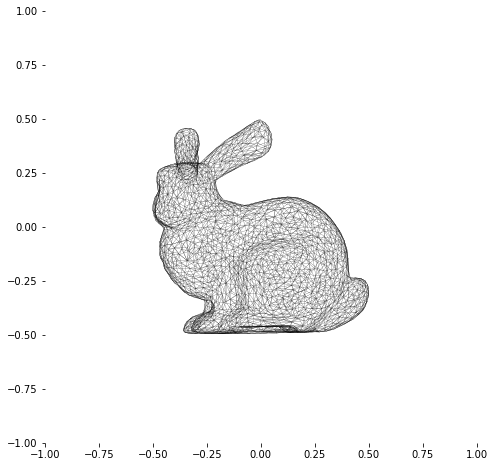

In [6]:
fig = matplotlib.pyplot.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1],
                  aspect=1, frameon=False)
collection = matplotlib.collections.PolyCollection(V[F][:,:,:2], closed=True, linewidth=0.1,
                            facecolor="None", edgecolor="black")
ax.add_collection(collection)
matplotlib.pyplot.show()

In [0]:
def frustum(left, right, bottom, top, znear, zfar):
    M = np.zeros((4, 4), dtype=np.float32)
    M[0, 0] = +2.0 * znear / (right - left)
    M[1, 1] = +2.0 * znear / (top - bottom)
    M[2, 2] = -(zfar + znear) / (zfar - znear)
    M[0, 2] = (right + left) / (right - left)
    M[2, 1] = (top + bottom) / (top - bottom)
    M[2, 3] = -2.0 * znear * zfar / (zfar - znear)
    M[3, 2] = -1.0
    return M

def perspective(fovy, aspect, znear, zfar):
    h = np.tan(0.5*np.radians(fovy)) * znear
    w = h * aspect
    return frustum(-w, w, -h, h, znear, zfar)

In [0]:
V = V - (0,0,3.5)
V = np.c_[V, np.ones(len(V))] @ perspective(25,1,1,100).T
V /= V[:,3].reshape(-1,1)

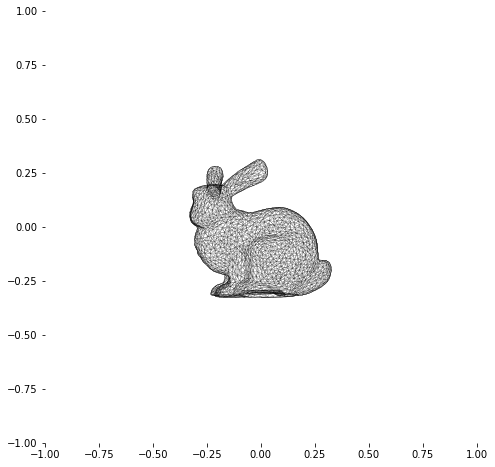

In [11]:
fig = matplotlib.pyplot.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1],
                  aspect=1, frameon=False)
collection = matplotlib.collections.PolyCollection(V[F][:,:,:2], closed=True, linewidth=0.1,
                            facecolor="None", edgecolor="black")
ax.add_collection(collection)
matplotlib.pyplot.show()

In [0]:
def translate(x, y, z):
    return np.array([[1, 0, 0, x],
                     [0, 1, 0, y],
                     [0, 0, 1, z],
                     [0, 0, 0, 1]], dtype=float)

def xrotate(theta):
    t = np.pi * theta / 180
    c, s = np.cos(t), np.sin(t)
    return np.array([[1, 0,  0, 0],
                     [0, c, -s, 0],
                     [0, s,  c, 0],
                     [0, 0,  0, 1]], dtype=float)

def yrotate(theta):
    t = np.pi * theta / 180
    c, s = np.cos(t), np.sin(t)
    return  np.array([[ c, 0, s, 0],
                      [ 0, 1, 0, 0],
                      [-s, 0, c, 0],
                      [ 0, 0, 0, 1]], dtype=float)

In [0]:
model = xrotate(20) @ yrotate(45) 
view  = translate(0,0,-3.5)
proj  = perspective(25, 1, 1, 100) 
MVP   = proj  @ view  @ model 

In [0]:
V = np.c_[V, np.ones(len(V))] @ MVP.T
V /= V[:,3].reshape(-1,1)

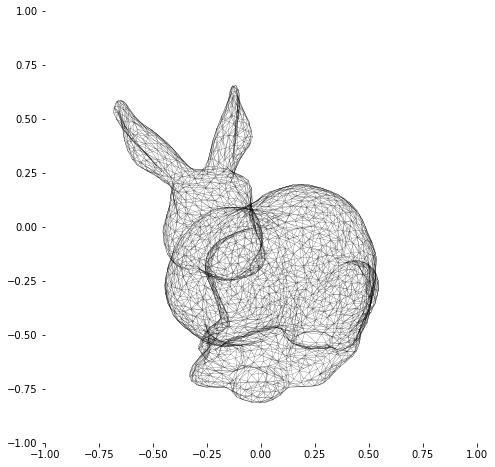

In [19]:
fig = matplotlib.pyplot.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1],
                  aspect=1, frameon=False)
collection = matplotlib.collections.PolyCollection(V[F][:,:,:2], closed=True, linewidth=0.1,
                            facecolor="None", edgecolor="black")
ax.add_collection(collection)
matplotlib.pyplot.show()